In [3]:
!pip install xlstm torcheval

In [5]:
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import FastICA
from sklearn import preprocessing
from tqdm import tqdm

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split


from xlstm import (
    xLSTMBlockStack,
    xLSTMBlockStackConfig,
    mLSTMBlockConfig,
    mLSTMLayerConfig,
    sLSTMBlockConfig,
    sLSTMLayerConfig,
    FeedForwardConfig,
)

import torch.utils.data as data
from torcheval.metrics import MulticlassAccuracy
import matplotlib.pyplot as plt

In [6]:
filenames = os.listdir('/kaggle/input/capstone-final-dataset/data')
filenames

['full-trial-4.csv',
 'hand-trial-4.csv',
 'arm-trial-2.csv',
 'hand-trial-3.csv',
 'hand-trial-5.csv',
 'hand-trial-2s.csv',
 'arm-trial-5.csv',
 'full-trial-2.csv',
 'arm-trial-4.csv',
 'full-trial-3.csv',
 'full-trial-1.csv',
 'arm-trial-1.csv',
 'arm-trial-3.csv']

In [37]:
x_batch = []
y_batch = []
window_size = 50 # 1 second
overlap = 25
# window_size = 100
# overlap = 75

# worse
# window_size = 128
# overlap = 25

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt

def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):
    ret = {key:[] for key in x.columns}
    
    for pos in x.columns:
        coeff = pywt.wavedec(x[pos], wavelet, mode="per")
        sigma = (1/0.6745) * maddest(coeff[-level])

        uthresh = sigma * np.sqrt(2*np.log(len(x)))
        coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

        ret[pos]=pywt.waverec(coeff, wavelet, mode='per')
    
    return pd.DataFrame(ret)

In [ ]:
# ica=FastICA(random_state = 97, max_iter=800)
# tempdf = None
# for filename in tqdm(filenames):
    
#     df = pd.read_csv(f'/kaggle/input/capstone-final-dataset/data/{filename}')
    
#     df = df.dropna()
    
#     X = df[['EEG.Cz', 'EEG.C3', 'EEG.FC5', 'EEG.T7', 'EEG.CP5', 'EEG.O1', 
#             'EEG.Pz', 'EEG.O2', 'EEG.CP6', 'EEG.T8', 'EEG.FC6', 'EEG.C4']]
#     if tempdf is None:
#         tempdf = X
#     else:
#         tempdf = pd.concat([tempdf, X],ignore_index=True)
# ica = ica.fit(tempdf)

for filename in tqdm(filenames):
    
    df = pd.read_csv(f'/kaggle/input/capstone-final-dataset/data/{filename}')
    
    df = df.dropna()
    
    X = df[['EEG.Cz', 'EEG.C3', 'EEG.FC5', 'EEG.T7', 'EEG.CP5', 'EEG.O1', 
            'EEG.Pz', 'EEG.O2', 'EEG.CP6', 'EEG.T8', 'EEG.FC6', 'EEG.C4']]
    Y = df['target']

    ica=FastICA(random_state = 97, max_iter=800)
    
    out_ica =ica.fit_transform(X)
    out_ica = ica.transform(X)

    X = pd.DataFrame(out_ica, columns = X.columns)

    # eeg_denoised = denoise(X, wavelet="db8")
    # X = eeg_denoised.copy()

    scaler = preprocessing.MinMaxScaler()
    X = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns, index=X.index)

    num_examples = X.shape[0]

    xn = X.to_numpy()
    yn = Y.to_numpy()

    if 'arm' in filename or 'hand' in filename:
        # arm and hand
        for i in range(128*60, 2*128*60, overlap): # 64 overlap
            if (i + window_size > 2*128*60):
                break
            xcurr = xn[i:i+window_size]
            ycurr = yn[i+window_size - 1]
            if ycurr == 2:
                ycurr = 1
            elif ycurr == 3 or ycurr == 4:
                ycurr = 2
            x_batch.append(xcurr)
            y_batch.append(ycurr)
        
        for i in range(2*128*60, 3*128*60, overlap): # 64 overlap
            if (i + window_size > 3*128*60):
                break
            xcurr = xn[i:i+window_size]
            ycurr = yn[i+window_size - 1]
            if ycurr == 2:
                ycurr = 1
            elif ycurr == 3 or ycurr == 4:
                ycurr = 2
            x_batch.append(xcurr)
            y_batch.append(ycurr)
        
        for i in range(3*128*60, xn.shape[0], overlap): # 64 overlap
            if (i + window_size > xn.shape[0]):
                break
            xcurr = xn[i:i+window_size]
            ycurr = yn[i+window_size - 1]
            if ycurr == 2:
                ycurr = 1
            elif ycurr == 3 or ycurr == 4:
                ycurr = 2
            x_batch.append(xcurr)
            y_batch.append(ycurr)
        
    elif 'full' in filename:
        # arm
        for i in range(128*60, int(1.5*128*60), overlap): # 64 overlap
            if (i + window_size > 1.5*128*60):
                break
            xcurr = xn[i:i+window_size]
            ycurr = yn[i+window_size - 1]
            if ycurr == 2:
                ycurr = 1
            elif ycurr == 3 or ycurr == 4:
                ycurr = 2
            x_batch.append(xcurr)
            y_batch.append(ycurr)
        
        for i in range(int(1.5*128*60), int(2*128*60), overlap): # 64 overlap
            if (i + window_size > 2*128*60):
                break
            xcurr = xn[i:i+window_size]
            ycurr = yn[i+window_size - 1]
            if ycurr == 2:
                ycurr = 1
            elif ycurr == 3 or ycurr == 4:
                ycurr = 2
            x_batch.append(xcurr)
            y_batch.append(ycurr)
        
        for i in range(2*128*60, int(2.5*128*60), overlap): # 64 overlap
            if (i + window_size > 2.5*128*60):
                break
            xcurr = xn[i:i+window_size]
            ycurr = yn[i+window_size - 1]
            if ycurr == 2:
                ycurr = 1
            elif ycurr == 3 or ycurr == 4:
                ycurr = 2
            x_batch.append(xcurr)
            y_batch.append(ycurr)

        for i in range(int(2.5*128*60), 3*128*60, overlap): # 64 overlap
            if (i + window_size > 3*128*60):
                break
            xcurr = xn[i:i+window_size]
            ycurr = yn[i+window_size - 1]
            if ycurr == 2:
                ycurr = 1
            elif ycurr == 3 or ycurr == 4:
                ycurr = 2
            x_batch.append(xcurr)
            y_batch.append(ycurr)

        for i in range(3*128*60, xn.shape[0], overlap): # 64 overlap
            if (i + window_size > xn.shape[0]):
                break
            xcurr = xn[i:i+window_size]
            ycurr = yn[i+window_size - 1]
            if ycurr == 2:
                ycurr = 1
            elif ycurr == 3 or ycurr == 4:
                ycurr = 2
            x_batch.append(xcurr)
            y_batch.append(ycurr)

100%|██████████| 13/13 [00:01<00:00, 12.30it/s]


In [40]:
x_batch = np.array(x_batch)
y_batch = np.array(y_batch)

In [41]:
x_batch.shape

(11879, 50, 12)

In [42]:
y_batch.shape

(11879,)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(x_batch, y_batch, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9503, 50, 12), (2376, 50, 12), (9503,), (2376,))

In [44]:
num_units = 100
# window_size = 128
num_epochs = 20

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [46]:
input_size = 12
sequence_length = window_size
num_layers = 2
hidden_size = 100
output_size = 3

In [47]:
mlstm_config = mLSTMBlockConfig()

# for cpu
# slstm_config = sLSTMBlockConfig()

# for gpu
slstm_config = sLSTMBlockConfig(slstm=sLSTMLayerConfig(
            backend="cuda"
        ))


cfg = xLSTMBlockStackConfig(
        mlstm_block=mlstm_config,
        slstm_block=slstm_config,
        num_blocks=3,
        embedding_dim=input_size,
        add_post_blocks_norm=True,
        
        _block_map = 1,
        context_length=sequence_length
    )

In [48]:
class TestModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(TestModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        # self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.xlstm = xLSTMBlockStack(cfg)
        # x -> (batch_size, sequence_length, input_size)
        self.fc = nn.Linear(input_size,output_size)
        # self.fc = nn.Linear(hidden_size,output_size)
        self.tanh = nn.Tanh()
    def forward(self, x):
        out = self.xlstm(x)
        # out, _ = self.lstm(x)
        # x -> (batch_size, sequence_length, hidden_size)
        out = self.tanh(out)
        out = out[:,-1,:]
        out = self.fc(out)
        return out

In [49]:
# # LSTM

# class TestModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size):
#         super(TestModel, self).__init__()
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.output_size = output_size
#         self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
#         # self.xlstm = xLSTMBlockStack(cfg)
#         # x -> (batch_size, sequence_length, input_size)
#         # self.fc = nn.Linear(input_size,output_size)
#         self.fc = nn.Linear(hidden_size,output_size)
#         self.tanh = nn.Tanh()
#     def forward(self, x):
#         # out = self.xlstm(x)
#         out, _ = self.lstm(x)
#         # x -> (batch_size, sequence_length, hidden_size)
#         out = self.tanh(out)
#         out = out[:,-1,:]
#         out = self.fc(out)
#         return out

In [50]:
model = TestModel(input_size, hidden_size, num_layers, output_size).to(device)

In [51]:
learning_rate=0.0001

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

In [53]:
num_epochs = 200

In [54]:
X_train = torch.tensor(X_train, dtype=torch.float, device=device)
X_test = torch.tensor(X_test, dtype=torch.float, device=device)
y_train = torch.tensor(y_train, dtype=torch.long, device=device)
y_test = torch.tensor(y_test, dtype=torch.long, device=device)

In [55]:
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=32)

In [56]:
testLoader = data.DataLoader(data.TensorDataset(X_test, y_test), shuffle=True, batch_size=32)

## xLSTM + wavelet

In [57]:
train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

In [58]:
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    totalYPred = []
    totalY = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            totalY.append(y_batch)
            totalYPred.append(model(X_batch))
    actualY = torch.cat(totalY, 0)
    predY = torch.cat(totalYPred, 0)
    metric = MulticlassAccuracy()
    metric.update(predY, actualY)
    train_acc = metric.compute()
    train_acc_list.append(train_acc.item())
    train_loss = nn.CrossEntropyLoss()
    train_loss = train_loss(predY, actualY).item()
    train_loss_list.append(train_loss)
    print("Epoch %d: Train Accuracy %.4f, Train Loss %.4f," % (epoch, train_acc, train_loss), end="")
    
    totalYPred = []
    totalY = []
    with torch.no_grad():
        for X_batch, y_batch in testLoader:
            totalY.append(y_batch)
            totalYPred.append(model(X_batch))
    actualY = torch.cat(totalY, 0)
    predY = torch.cat(totalYPred, 0)
    metric = MulticlassAccuracy()
    metric.update(predY, actualY)
    test_acc = metric.compute()
    
    test_acc_list.append(test_acc.item())
    test_loss = nn.CrossEntropyLoss()
    test_loss = test_loss(predY, actualY).item()
    test_loss_list.append(test_loss)
    print(" Test Accuracy %.4f, Test Loss %.4f" % (test_acc, test_loss))
    del totalYPred
    del totalY
    del actualY
    del predY

Epoch 0: Train Accuracy 0.5299, Train Loss 0.9859, Test Accuracy 0.5328, Test Loss 0.9838
Epoch 1: Train Accuracy 0.5575, Train Loss 0.9150, Test Accuracy 0.5560, Test Loss 0.9178
Epoch 2: Train Accuracy 0.5811, Train Loss 0.8593, Test Accuracy 0.5745, Test Loss 0.8636
Epoch 3: Train Accuracy 0.6049, Train Loss 0.8171, Test Accuracy 0.5939, Test Loss 0.8217
Epoch 4: Train Accuracy 0.6213, Train Loss 0.7670, Test Accuracy 0.6128, Test Loss 0.7786
Epoch 5: Train Accuracy 0.6361, Train Loss 0.7302, Test Accuracy 0.6242, Test Loss 0.7475
Epoch 6: Train Accuracy 0.6542, Train Loss 0.6923, Test Accuracy 0.6444, Test Loss 0.7120
Epoch 7: Train Accuracy 0.6646, Train Loss 0.6674, Test Accuracy 0.6620, Test Loss 0.6866
Epoch 8: Train Accuracy 0.6679, Train Loss 0.6494, Test Accuracy 0.6574, Test Loss 0.6716
Epoch 9: Train Accuracy 0.6820, Train Loss 0.6206, Test Accuracy 0.6721, Test Loss 0.6421
Epoch 10: Train Accuracy 0.6842, Train Loss 0.6050, Test Accuracy 0.6747, Test Loss 0.6297
Epoch 11:

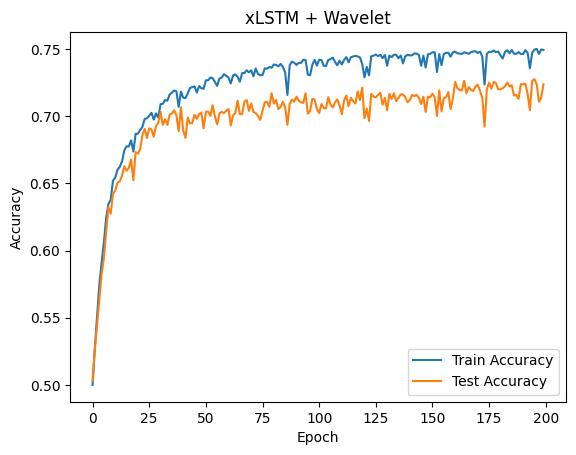

In [61]:
# plt.figure(figsize = (15,5))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(test_acc_list)), test_acc_list)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("xLSTM + Wavelet")
plt.legend(["Train Accuracy","Test Accuracy"],loc = "lower right")

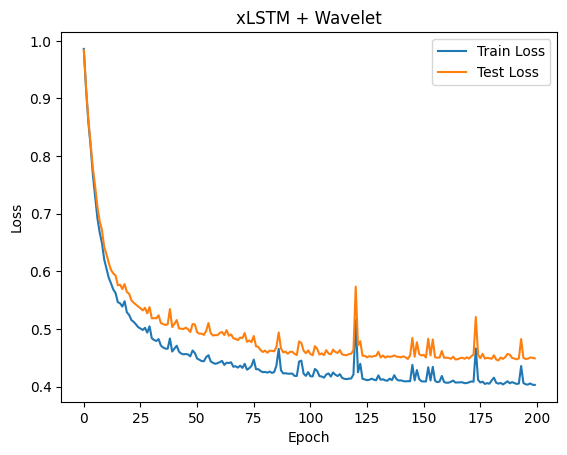

In [64]:
# plt.figure(figsize = (15,5))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(test_loss_list)), test_loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("xLSTM + Wavelet")
plt.legend(["Train Loss","Test Loss"],loc = "upper right")

## xLSTM + ICA
## Combining hand and arm
## window 50, overlapp 25

In [268]:
train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

In [269]:
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    totalYPred = []
    totalY = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            totalY.append(y_batch)
            totalYPred.append(model(X_batch))
    actualY = torch.cat(totalY, 0)
    predY = torch.cat(totalYPred, 0)
    metric = MulticlassAccuracy()
    metric.update(predY, actualY)
    train_acc = metric.compute()
    train_acc_list.append(train_acc.item())
    train_loss = nn.CrossEntropyLoss()
    train_loss = train_loss(predY, actualY).item()
    train_loss_list.append(train_loss)
    print("Epoch %d: Train Accuracy %.4f, Train Loss %.4f," % (epoch, train_acc, train_loss), end="")
    
    totalYPred = []
    totalY = []
    with torch.no_grad():
        for X_batch, y_batch in testLoader:
            totalY.append(y_batch)
            totalYPred.append(model(X_batch))
    actualY = torch.cat(totalY, 0)
    predY = torch.cat(totalYPred, 0)
    metric = MulticlassAccuracy()
    metric.update(predY, actualY)
    test_acc = metric.compute()
    
    test_acc_list.append(test_acc.item())
    test_loss = nn.CrossEntropyLoss()
    test_loss = test_loss(predY, actualY).item()
    test_loss_list.append(test_loss)
    print(" Test Accuracy %.4f, Test Loss %.4f" % (test_acc, test_loss))
    del totalYPred
    del totalY
    del actualY
    del predY

Epoch 0: Train Accuracy 0.4473, Train Loss 1.0606, Test Accuracy 0.4310, Test Loss 1.0700
Epoch 1: Train Accuracy 0.5335, Train Loss 0.9852, Test Accuracy 0.5030, Test Loss 1.0012
Epoch 2: Train Accuracy 0.5768, Train Loss 0.9100, Test Accuracy 0.5392, Test Loss 0.9318
Epoch 3: Train Accuracy 0.6094, Train Loss 0.8394, Test Accuracy 0.5924, Test Loss 0.8626
Epoch 4: Train Accuracy 0.6404, Train Loss 0.7714, Test Accuracy 0.6227, Test Loss 0.7994
Epoch 5: Train Accuracy 0.6604, Train Loss 0.7177, Test Accuracy 0.6354, Test Loss 0.7517
Epoch 6: Train Accuracy 0.6767, Train Loss 0.6711, Test Accuracy 0.6537, Test Loss 0.7002
Epoch 7: Train Accuracy 0.6879, Train Loss 0.6347, Test Accuracy 0.6670, Test Loss 0.6660
Epoch 8: Train Accuracy 0.6971, Train Loss 0.6044, Test Accuracy 0.6742, Test Loss 0.6349
Epoch 9: Train Accuracy 0.6972, Train Loss 0.5880, Test Accuracy 0.6861, Test Loss 0.6148
Epoch 10: Train Accuracy 0.7094, Train Loss 0.5627, Test Accuracy 0.6853, Test Loss 0.5913
Epoch 11:

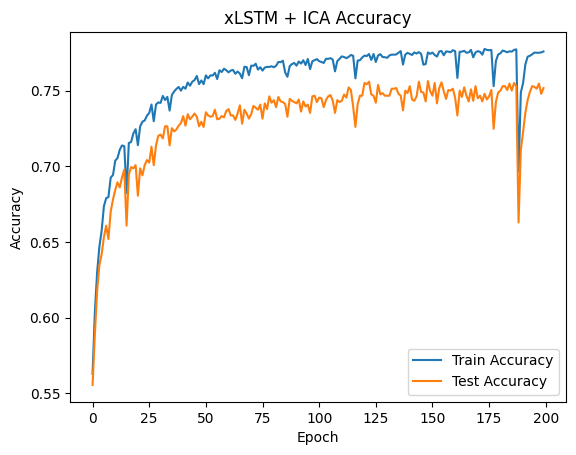

In [60]:
# plt.figure(figsize = (15,5))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(test_acc_list)), test_acc_list)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("xLSTM + ICA Accuracy")
plt.legend(["Train Accuracy","Test Accuracy"],loc = "lower right")

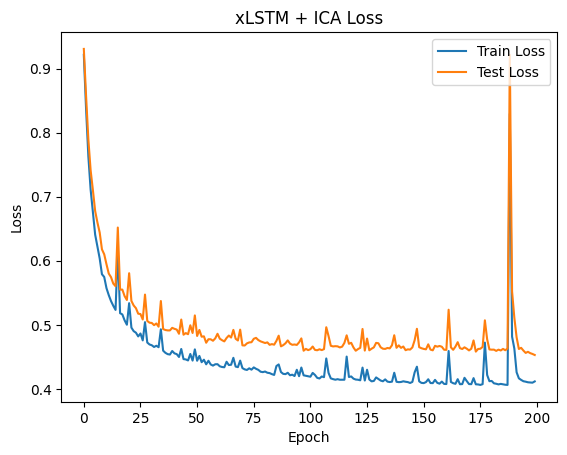

In [61]:
# plt.figure(figsize = (15,5))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(test_loss_list)), test_loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("xLSTM + ICA Loss")
plt.legend(["Train Loss","Test Loss"],loc = "upper right")

## LSTM
## Combining hand and arm
## window 50, overlapp 25

In [277]:
train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

In [278]:
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    totalYPred = []
    totalY = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            totalY.append(y_batch)
            totalYPred.append(model(X_batch))
    actualY = torch.cat(totalY, 0)
    predY = torch.cat(totalYPred, 0)
    metric = MulticlassAccuracy()
    metric.update(predY, actualY)
    train_acc = metric.compute()
    train_acc_list.append(train_acc.item())
    train_loss = nn.CrossEntropyLoss()
    train_loss = train_loss(predY, actualY).item()
    train_loss_list.append(train_loss)
    print("Epoch %d: Train Accuracy %.4f, Train Loss %.4f," % (epoch, train_acc, train_loss), end="")
    
    totalYPred = []
    totalY = []
    with torch.no_grad():
        for X_batch, y_batch in testLoader:
            totalY.append(y_batch)
            totalYPred.append(model(X_batch))
    actualY = torch.cat(totalY, 0)
    predY = torch.cat(totalYPred, 0)
    metric = MulticlassAccuracy()
    metric.update(predY, actualY)
    test_acc = metric.compute()
    
    test_acc_list.append(test_acc.item())
    test_loss = nn.CrossEntropyLoss()
    test_loss = test_loss(predY, actualY).item()
    test_loss_list.append(test_loss)
    print(" Test Accuracy %.4f, Test Loss %.4f" % (test_acc, test_loss))
    del totalYPred
    del totalY
    del actualY
    del predY

Epoch 0: Train Accuracy 0.4064, Train Loss 1.0827, Test Accuracy 0.4221, Test Loss 1.0794
Epoch 1: Train Accuracy 0.4872, Train Loss 1.0015, Test Accuracy 0.4874, Test Loss 1.0006
Epoch 2: Train Accuracy 0.4847, Train Loss 0.9997, Test Accuracy 0.4891, Test Loss 1.0009
Epoch 3: Train Accuracy 0.4977, Train Loss 0.9757, Test Accuracy 0.5038, Test Loss 0.9783
Epoch 4: Train Accuracy 0.5230, Train Loss 0.9166, Test Accuracy 0.5257, Test Loss 0.9228
Epoch 5: Train Accuracy 0.5198, Train Loss 0.8949, Test Accuracy 0.5215, Test Loss 0.9105
Epoch 6: Train Accuracy 0.5069, Train Loss 0.9262, Test Accuracy 0.5055, Test Loss 0.9409
Epoch 7: Train Accuracy 0.5267, Train Loss 0.8916, Test Accuracy 0.5278, Test Loss 0.9015
Epoch 8: Train Accuracy 0.5254, Train Loss 0.8897, Test Accuracy 0.5244, Test Loss 0.9070
Epoch 9: Train Accuracy 0.5295, Train Loss 0.8730, Test Accuracy 0.5332, Test Loss 0.8799
Epoch 10: Train Accuracy 0.5386, Train Loss 0.8567, Test Accuracy 0.5379, Test Loss 0.8739
Epoch 11:

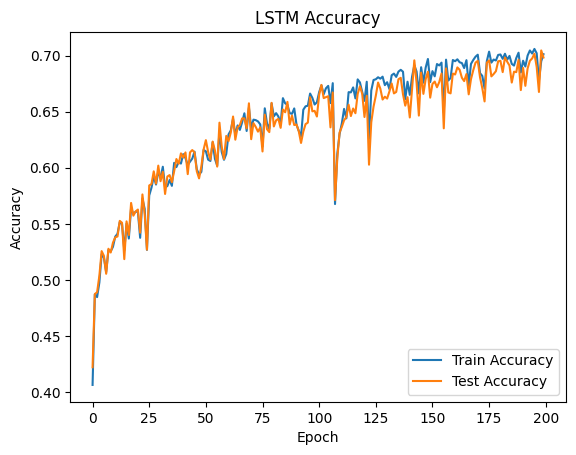

In [280]:
# plt.figure(figsize = (15,5))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(test_acc_list)), test_acc_list)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("LSTM Accuracy")
plt.legend(["Train Accuracy","Test Accuracy"],loc = "lower right")

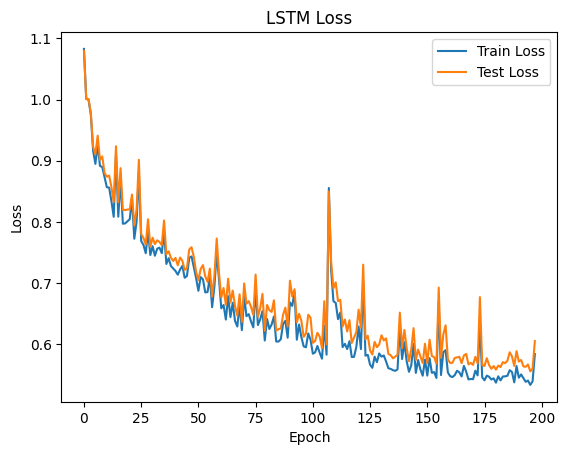

In [282]:
# plt.figure(figsize = (15,5))
plt.plot(range(len(train_loss_list)-2), train_loss_list[:-2])
plt.plot(range(len(test_loss_list)-2), test_loss_list[:-2])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LSTM Loss")
plt.legend(["Train Loss","Test Loss"],loc = "upper right")

## xLSTM
## Combining hand and arm
## window 64, overlapp 32

In [26]:
train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

In [27]:
# 75 75
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    totalYPred = []
    totalY = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            totalY.append(y_batch)
            totalYPred.append(model(X_batch))
    actualY = torch.cat(totalY, 0)
    predY = torch.cat(totalYPred, 0)
    metric = MulticlassAccuracy()
    metric.update(predY, actualY)
    train_acc = metric.compute()
    train_acc_list.append(train_acc.item())
    train_loss = nn.CrossEntropyLoss()
    train_loss = train_loss(predY, actualY).item()
    train_loss_list.append(train_loss)
    print("Epoch %d: Train Accuracy %.4f, Train Loss %.4f," % (epoch, train_acc, train_loss), end="")
    
    totalYPred = []
    totalY = []
    with torch.no_grad():
        for X_batch, y_batch in testLoader:
            totalY.append(y_batch)
            totalYPred.append(model(X_batch))
    actualY = torch.cat(totalY, 0)
    predY = torch.cat(totalYPred, 0)
    metric = MulticlassAccuracy()
    metric.update(predY, actualY)
    test_acc = metric.compute()
    
    test_acc_list.append(test_acc.item())
    test_loss = nn.CrossEntropyLoss()
    test_loss = test_loss(predY, actualY).item()
    test_loss_list.append(test_loss)
    print(" Test Accuracy %.4f, Test Loss %.4f" % (test_acc, test_loss))
    del totalYPred
    del totalY
    del actualY
    del predY

Epoch 0: Train Accuracy 0.4989, Train Loss 0.9876, Test Accuracy 0.4933, Test Loss 0.9946
Epoch 1: Train Accuracy 0.5541, Train Loss 0.9129, Test Accuracy 0.5556, Test Loss 0.9246
Epoch 2: Train Accuracy 0.5983, Train Loss 0.8455, Test Accuracy 0.6006, Test Loss 0.8602
Epoch 3: Train Accuracy 0.6235, Train Loss 0.7745, Test Accuracy 0.6145, Test Loss 0.7949
Epoch 4: Train Accuracy 0.6487, Train Loss 0.7188, Test Accuracy 0.6465, Test Loss 0.7389
Epoch 5: Train Accuracy 0.6593, Train Loss 0.6810, Test Accuracy 0.6532, Test Loss 0.7009
Epoch 6: Train Accuracy 0.6787, Train Loss 0.6334, Test Accuracy 0.6717, Test Loss 0.6546
Epoch 7: Train Accuracy 0.6839, Train Loss 0.6061, Test Accuracy 0.6742, Test Loss 0.6257
Epoch 8: Train Accuracy 0.6939, Train Loss 0.5875, Test Accuracy 0.6785, Test Loss 0.6085
Epoch 9: Train Accuracy 0.6999, Train Loss 0.5640, Test Accuracy 0.6932, Test Loss 0.5772
Epoch 10: Train Accuracy 0.7057, Train Loss 0.5513, Test Accuracy 0.6970, Test Loss 0.5650
Epoch 11:

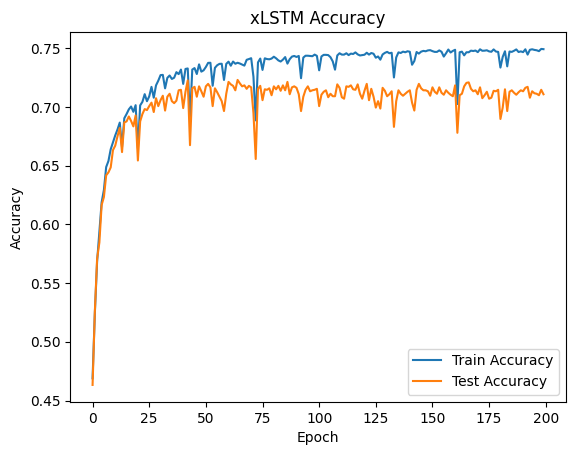

In [31]:
# plt.figure(figsize = (15,5))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(test_acc_list)), test_acc_list)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("xLSTM Accuracy")
plt.legend(["Train Accuracy","Test Accuracy"],loc = "lower right")

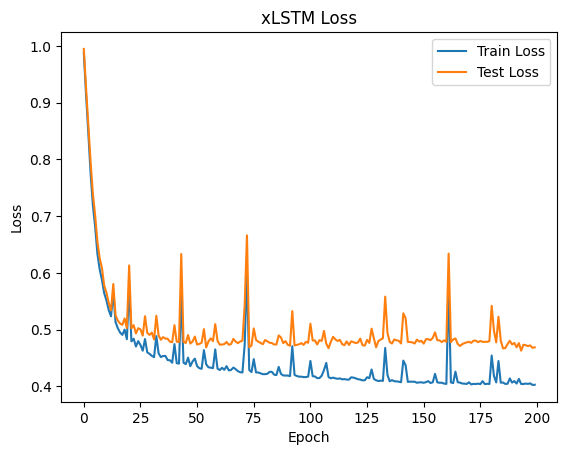

In [34]:
# plt.figure(figsize = (15,5))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(test_loss_list)), test_loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("xLSTM Loss")
plt.legend(["Train Loss","Test Loss"],loc = "upper right")

In [224]:
ttrain_acc_list = train_acc_list
ttest_acc_list = test_acc_list
ttrain_loss_list = train_loss_list
ttest_loss_list = test_loss_list

In [71]:
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    totalYPred = []
    totalY = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            totalY.append(y_batch)
            totalYPred.append(model(X_batch))
    actualY = torch.cat(totalY, 0)
    predY = torch.cat(totalYPred, 0)
    metric = MulticlassAccuracy()
    metric.update(predY, actualY)
    train_acc = metric.compute()
    train_acc_list.append(train_acc.item())
    train_loss = nn.CrossEntropyLoss()
    train_loss = train_loss(predY, actualY).item()
    train_loss_list.append(train_loss)
    print("Epoch %d: Train Accuracy %.4f, Train Loss %.4f," % (epoch, train_acc, train_loss), end="")
    
    totalYPred = []
    totalY = []
    with torch.no_grad():
        for X_batch, y_batch in testLoader:
            totalY.append(y_batch)
            totalYPred.append(model(X_batch))
    actualY = torch.cat(totalY, 0)
    predY = torch.cat(totalYPred, 0)
    metric = MulticlassAccuracy()
    metric.update(predY, actualY)
    test_acc = metric.compute()
    
    test_acc_list.append(test_acc.item())
    test_loss = nn.CrossEntropyLoss()
    test_loss = test_loss(predY, actualY).item()
    test_loss_list.append(test_loss)
    print(" Test Accuracy %.4f, Test Loss %.4f" % (test_acc, test_loss))
    del totalYPred
    del totalY
    del actualY
    del predY

Epoch 0: Train Accuracy 0.4466, Train Loss 1.0291, Test Accuracy 0.4487, Test Loss 1.0265
Epoch 1: Train Accuracy 0.5336, Train Loss 0.9421, Test Accuracy 0.5370, Test Loss 0.9380
Epoch 2: Train Accuracy 0.5713, Train Loss 0.8695, Test Accuracy 0.5664, Test Loss 0.8751
Epoch 3: Train Accuracy 0.6100, Train Loss 0.8084, Test Accuracy 0.6101, Test Loss 0.8180
Epoch 4: Train Accuracy 0.6205, Train Loss 0.7627, Test Accuracy 0.6210, Test Loss 0.7709
Epoch 5: Train Accuracy 0.6411, Train Loss 0.7166, Test Accuracy 0.6437, Test Loss 0.7256
Epoch 6: Train Accuracy 0.6491, Train Loss 0.6829, Test Accuracy 0.6471, Test Loss 0.6914
Epoch 7: Train Accuracy 0.6535, Train Loss 0.6716, Test Accuracy 0.6462, Test Loss 0.6831
Epoch 8: Train Accuracy 0.6682, Train Loss 0.6338, Test Accuracy 0.6630, Test Loss 0.6454
Epoch 9: Train Accuracy 0.6751, Train Loss 0.6154, Test Accuracy 0.6681, Test Loss 0.6273
Epoch 10: Train Accuracy 0.6812, Train Loss 0.5944, Test Accuracy 0.6731, Test Loss 0.6091
Epoch 11:

# Rest Hyperparameter tuning on xLSTM + ICA

## Combining hand and arm
## window 50, overlapp 25

In [101]:
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    totalYPred = []
    totalY = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            totalY.append(y_batch)
            totalYPred.append(model(X_batch))
    actualY = torch.cat(totalY, 0)
    predY = torch.cat(totalYPred, 0)
    metric = MulticlassAccuracy()
    metric.update(predY, actualY)
    train_acc = metric.compute()
    print("Epoch %d: Train Accuracy %.4f," % (epoch, train_acc), end="")

    totalYPred = []
    totalY = []
    with torch.no_grad():
        for X_batch, y_batch in testLoader:
            totalY.append(y_batch)
            totalYPred.append(model(X_batch))
    actualY = torch.cat(totalY, 0)
    predY = torch.cat(totalYPred, 0)
    metric = MulticlassAccuracy()
    metric.update(predY, actualY)
    test_acc = metric.compute()
    print(" Test Accuracy %.4f" % (test_acc))
    del totalYPred
    del totalY
    del actualY
    del predY

Epoch 0: Train Accuracy 0.4144, Test Accuracy 0.4036
Epoch 1: Train Accuracy 0.5029, Test Accuracy 0.4760
Epoch 2: Train Accuracy 0.5452, Test Accuracy 0.5210
Epoch 3: Train Accuracy 0.5877, Test Accuracy 0.5543
Epoch 4: Train Accuracy 0.6149, Test Accuracy 0.5808
Epoch 5: Train Accuracy 0.6420, Test Accuracy 0.6035
Epoch 6: Train Accuracy 0.6593, Test Accuracy 0.6309
Epoch 7: Train Accuracy 0.6696, Test Accuracy 0.6359
Epoch 8: Train Accuracy 0.6821, Test Accuracy 0.6503
Epoch 9: Train Accuracy 0.6928, Test Accuracy 0.6604
Epoch 10: Train Accuracy 0.6965, Test Accuracy 0.6637
Epoch 11: Train Accuracy 0.7023, Test Accuracy 0.6604
Epoch 12: Train Accuracy 0.7045, Test Accuracy 0.6747
Epoch 13: Train Accuracy 0.7116, Test Accuracy 0.6768
Epoch 14: Train Accuracy 0.7182, Test Accuracy 0.6827
Epoch 15: Train Accuracy 0.7176, Test Accuracy 0.6831
Epoch 16: Train Accuracy 0.7225, Test Accuracy 0.6848
Epoch 17: Train Accuracy 0.7293, Test Accuracy 0.6919
Epoch 18: Train Accuracy 0.7286, Test 

KeyboardInterrupt: 

## Not Combining hand and arm
## window 50, overlapp 25

In [81]:
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    totalYPred = []
    totalY = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            totalY.append(y_batch)
            totalYPred.append(model(X_batch))
    actualY = torch.cat(totalY, 0)
    predY = torch.cat(totalYPred, 0)
    metric = MulticlassAccuracy()
    metric.update(predY, actualY)
    train_acc = metric.compute()
    print("Epoch %d: Train Accuracy %.4f," % (epoch, train_acc), end="")

    totalYPred = []
    totalY = []
    with torch.no_grad():
        for X_batch, y_batch in testLoader:
            totalY.append(y_batch)
            totalYPred.append(model(X_batch))
    actualY = torch.cat(totalY, 0)
    predY = torch.cat(totalYPred, 0)
    metric = MulticlassAccuracy()
    metric.update(predY, actualY)
    test_acc = metric.compute()
    print(" Test Accuracy %.4f" % (test_acc))
    del totalYPred
    del totalY
    del actualY
    del predY

Epoch 0: Train Accuracy 0.3436, Test Accuracy 0.3451
Epoch 1: Train Accuracy 0.3795, Test Accuracy 0.3859
Epoch 2: Train Accuracy 0.4166, Test Accuracy 0.4226
Epoch 3: Train Accuracy 0.4422, Test Accuracy 0.4394
Epoch 4: Train Accuracy 0.4689, Test Accuracy 0.4583
Epoch 5: Train Accuracy 0.4933, Test Accuracy 0.4806
Epoch 6: Train Accuracy 0.5145, Test Accuracy 0.4962
Epoch 7: Train Accuracy 0.5333, Test Accuracy 0.5042
Epoch 8: Train Accuracy 0.5450, Test Accuracy 0.5130
Epoch 9: Train Accuracy 0.5526, Test Accuracy 0.5265
Epoch 10: Train Accuracy 0.5612, Test Accuracy 0.5345
Epoch 11: Train Accuracy 0.5705, Test Accuracy 0.5434
Epoch 12: Train Accuracy 0.5776, Test Accuracy 0.5484
Epoch 13: Train Accuracy 0.5761, Test Accuracy 0.5556
Epoch 14: Train Accuracy 0.5847, Test Accuracy 0.5614
Epoch 15: Train Accuracy 0.5880, Test Accuracy 0.5644
Epoch 16: Train Accuracy 0.5938, Test Accuracy 0.5737
Epoch 17: Train Accuracy 0.5975, Test Accuracy 0.5770
Epoch 18: Train Accuracy 0.5877, Test 

KeyboardInterrupt: 

## Combining hand and arm
## window 128, overlapp 64

In [58]:
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    totalYPred = []
    totalY = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            totalY.append(y_batch)
            totalYPred.append(model(X_batch))
    actualY = torch.cat(totalY, 0)
    predY = torch.cat(totalYPred, 0)
    metric = MulticlassAccuracy()
    metric.update(predY, actualY)
    train_acc = metric.compute()
    print("Epoch %d: Train Accuracy %.4f," % (epoch, train_acc), end="")

    totalYPred = []
    totalY = []
    with torch.no_grad():
        for X_batch, y_batch in testLoader:
            totalY.append(y_batch)
            totalYPred.append(model(X_batch))
    actualY = torch.cat(totalY, 0)
    predY = torch.cat(totalYPred, 0)
    metric = MulticlassAccuracy()
    metric.update(predY, actualY)
    test_acc = metric.compute()
    print(" Test Accuracy %.4f" % (test_acc))
    del totalYPred
    del totalY
    del actualY
    del predY

Epoch 0: Train Accuracy 0.4361, Test Accuracy 0.4371
Epoch 1: Train Accuracy 0.4955, Test Accuracy 0.4718
Epoch 2: Train Accuracy 0.5170, Test Accuracy 0.4870
Epoch 3: Train Accuracy 0.5609, Test Accuracy 0.5260
Epoch 4: Train Accuracy 0.5674, Test Accuracy 0.5260
Epoch 5: Train Accuracy 0.5512, Test Accuracy 0.5119
Epoch 6: Train Accuracy 0.5970, Test Accuracy 0.5629
Epoch 7: Train Accuracy 0.6187, Test Accuracy 0.5868
Epoch 8: Train Accuracy 0.6098, Test Accuracy 0.5727
Epoch 9: Train Accuracy 0.6583, Test Accuracy 0.6215
Epoch 10: Train Accuracy 0.6556, Test Accuracy 0.6280
Epoch 11: Train Accuracy 0.6581, Test Accuracy 0.6302
Epoch 12: Train Accuracy 0.6681, Test Accuracy 0.6280
Epoch 13: Train Accuracy 0.6757, Test Accuracy 0.6453
Epoch 14: Train Accuracy 0.6820, Test Accuracy 0.6432
Epoch 15: Train Accuracy 0.6806, Test Accuracy 0.6432
Epoch 16: Train Accuracy 0.6757, Test Accuracy 0.6377
Epoch 17: Train Accuracy 0.6849, Test Accuracy 0.6464
Epoch 18: Train Accuracy 0.6912, Test 

KeyboardInterrupt: 

## Not Combining hand and arm
## window 128, overlapp 64

In [39]:
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval()
    totalYPred = []
    totalY = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            totalY.append(y_batch)
            totalYPred.append(model(X_batch))
    actualY = torch.cat(totalY, 0)
    predY = torch.cat(totalYPred, 0)
    metric = MulticlassAccuracy()
    metric.update(predY, actualY)
    train_acc = metric.compute()
    print("Epoch %d: Train Accuracy %.4f," % (epoch, train_acc), end="")

    totalYPred = []
    totalY = []
    with torch.no_grad():
        for X_batch, y_batch in testLoader:
            totalY.append(y_batch)
            totalYPred.append(model(X_batch))
    actualY = torch.cat(totalY, 0)
    predY = torch.cat(totalYPred, 0)
    metric = MulticlassAccuracy()
    metric.update(predY, actualY)
    test_acc = metric.compute()
    print(" Test Accuracy %.4f" % (test_acc))
    del totalYPred
    del totalY
    del actualY
    del predY

Epoch 0: Train Accuracy 0.2814, Test Accuracy 0.2885
Epoch 1: Train Accuracy 0.3148, Test Accuracy 0.3145
Epoch 2: Train Accuracy 0.3528, Test Accuracy 0.3525
Epoch 3: Train Accuracy 0.3805, Test Accuracy 0.3742
Epoch 4: Train Accuracy 0.4092, Test Accuracy 0.3991
Epoch 5: Train Accuracy 0.4269, Test Accuracy 0.4002
Epoch 6: Train Accuracy 0.4516, Test Accuracy 0.4273
Epoch 7: Train Accuracy 0.4632, Test Accuracy 0.4262
Epoch 8: Train Accuracy 0.4773, Test Accuracy 0.4403
Epoch 9: Train Accuracy 0.4934, Test Accuracy 0.4566
Epoch 10: Train Accuracy 0.4999, Test Accuracy 0.4523
Epoch 11: Train Accuracy 0.5066, Test Accuracy 0.4610
Epoch 12: Train Accuracy 0.5104, Test Accuracy 0.4664
Epoch 13: Train Accuracy 0.5243, Test Accuracy 0.4685
Epoch 14: Train Accuracy 0.5327, Test Accuracy 0.4761
Epoch 15: Train Accuracy 0.5349, Test Accuracy 0.4761
Epoch 16: Train Accuracy 0.5379, Test Accuracy 0.4826
Epoch 17: Train Accuracy 0.5430, Test Accuracy 0.4935
Epoch 18: Train Accuracy 0.5476, Test 

KeyboardInterrupt: 

In [4]:
df = pd.read_csv('/kaggle/input/capstone-final-dataset/data/arm-trial-1.csv')
df.head()

,Unnamed: 0,EEG.Cz,EEG.C3,EEG.FC5,EEG.T7,EEG.CP5,EEG.O1,EEG.Pz,EEG.O2,EEG.CP6,EEG.T8,EEG.FC6,EEG.C4,target
0,0,-28.726574,-21.566540,-9.961324,-26.926275,28.333508,80.673996,-52.204895,31.735275,0.814791,-2.509130,-5.763516,-11.554217,-1
1,1,-15.377848,-14.884973,-6.365208,-20.239349,31.891329,85.204094,-43.443459,32.215847,10.547822,3.641071,-3.196214,-5.907278,-1
2,2,-13.313239,-14.870088,-11.481920,-25.854494,32.371746,74.360428,-44.936939,19.888248,8.488044,-3.022570,-11.902248,-6.925986,-1
3,3,-13.299926,-19.465986,-14.544284,-28.902487,31.314756,63.015297,-51.039696,6.036052,10.016479,-4.556470,-14.451885,-8.968291,-1
4,4,-5.602010,-15.860367,-14.529739,-28.873585,30.258827,64.489204,-55.599426,6.030016,14.104923,-3.527298,-8.802049,-4.860861,-1


In [5]:
df.shape

(30651, 14)

In [6]:
df = df.dropna()
df.shape

(30651, 14)

In [7]:
df.columns

Index(['Unnamed: 0', 'EEG.Cz', 'EEG.C3', 'EEG.FC5', 'EEG.T7', 'EEG.CP5',
       'EEG.O1', 'EEG.Pz', 'EEG.O2', 'EEG.CP6', 'EEG.T8', 'EEG.FC6', 'EEG.C4',
       'target'],
      dtype='object')

In [20]:
X = df[['EEG.Cz', 'EEG.C3', 'EEG.FC5', 'EEG.T7', 'EEG.CP5',
       'EEG.O1', 'EEG.Pz', 'EEG.O2', 'EEG.CP6', 'EEG.T8', 'EEG.FC6', 'EEG.C4']]
Y = df['target']

In [10]:
ica=FastICA(random_state = 97, max_iter=800)

out_ica =ica.fit_transform(X)

/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [11]:
out_ica.shape

(30651, 12)

In [12]:
X = pd.DataFrame(out_ica, columns = X.columns)
X.head()

,EEG.Cz,EEG.C3,EEG.FC5,EEG.T7,EEG.CP5,EEG.O1,EEG.Pz,EEG.O2,EEG.CP6,EEG.T8,EEG.FC6,EEG.C4
0,0.000723,-0.002468,0.004973,-0.000256,-0.000647,-0.002695,0.002937,-0.002635,0.000186,0.009398,0.001261,-0.001385
1,-0.001016,-0.002434,0.005990,-0.000127,-0.000521,-0.002607,0.002789,-0.001858,0.000260,0.007724,0.000339,-0.001550
2,-0.002589,-0.002305,0.004499,-0.000016,-0.000302,-0.002985,0.003212,-0.001228,0.000159,0.005136,-0.000845,-0.002860
3,-0.002528,-0.002511,0.005966,0.000157,-0.000221,-0.003169,0.003256,-0.000715,0.000190,0.002260,-0.000677,-0.005602
4,-0.003918,-0.003180,0.005871,0.000092,-0.000013,-0.002909,0.003575,-0.000143,0.000125,0.001427,0.000054,-0.005334


In [13]:
scaler = preprocessing.MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns, index=X.index)

In [15]:
X.head()

,EEG.Cz,EEG.C3,EEG.FC5,EEG.T7,EEG.CP5,EEG.O1,EEG.Pz,EEG.O2,EEG.CP6,EEG.T8,EEG.FC6,EEG.C4
0,0.533011,0.422955,0.651072,0.466745,0.573769,0.424166,0.666487,0.694041,0.539663,0.700539,0.394001,0.468502
1,0.500681,0.423340,0.670463,0.469209,0.575163,0.425354,0.664974,0.702279,0.540916,0.672788,0.383131,0.465286
2,0.471423,0.424797,0.642027,0.471327,0.577578,0.420216,0.669288,0.708966,0.539212,0.629906,0.369155,0.439760
3,0.472571,0.422473,0.670004,0.474641,0.578471,0.417715,0.669741,0.714409,0.539727,0.582251,0.371138,0.386303
4,0.446710,0.414934,0.668192,0.473402,0.580763,0.421257,0.672997,0.720471,0.538637,0.568448,0.379768,0.391520


In [16]:
num_examples = X.shape[0]

In [17]:
window_size = 128 # 1 second

In [21]:
xn = X.to_numpy()
yn = Y.to_numpy()

In [22]:
yn[window_size]

-1

In [23]:
xn[1:1 + window_size].shape

(128, 12)

In [32]:
x_batch = []
y_batch = []

In [33]:
# arm

for i in tqdm(range(128*60, 2*128*60, 64)): # 64 overlap
    if (i + 128 > 2*128*60):
        break
    xcurr = xn[i:i+window_size]
    ycurr = yn[i+window_size - 1]
    x_batch.append(xcurr)
    y_batch.append(ycurr)

for i in tqdm(range(2*128*60, 3*128*60, 64)): # 64 overlap
    if (i + 128 > 3*128*60):
        break
    xcurr = xn[i:i+window_size]
    ycurr = yn[i+window_size - 1]
    x_batch.append(xcurr)
    y_batch.append(ycurr)

for i in tqdm(range(3*128*60, xn.shape[0], 64)): # 64 overlap
    if (i + 128 > xn.shape[0]):
        break
    xcurr = xn[i:i+window_size]
    ycurr = yn[i+window_size - 1]
    x_batch.append(xcurr)
    y_batch.append(ycurr)



 98%|█████████▊| 117/119 [00:00<00:00, 285476.19it/s]


In [34]:
x_batch = np.array(x_batch)
y_batch = np.array(y_batch)

In [35]:
x_batch.shape

(355, 128, 12)

In [36]:
y_batch

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,